In [1]:
# Notebook for our experiemnt on slabs
"""The value of index n can be extracted by comparing the M(theta) data with functional shapes 
computed for a set of candidate n-values."""

'The value of index n can be extracted by comparing the M(theta) data with functional shapes \ncomputed for a set of candidate n-values.'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

In [8]:
# T = 1e-3 # thickness of slab in mm
n = 1.5 # guess of index of refraction
lambda_HeNe = 632.99e-9 # wavelength of laser in nm (vacuum)
path = '/Users/andrewbowen/OpticsLab/Interferometry/slabs/data/'

In [158]:
# Defining functions we will use later

def get_n(theta, M, T):
    """Function to get index of refraction; from TeachSpin article Chap 11-5"""
#     Converting theta to radians (fed in in degrees)
    theta_rad = (theta *np.pi) / 180
    
    
    alpha = (M * lambda_HeNe)/ (2*T)
    n = ((alpha**2) + 2 *((1 - np.cos(theta_rad))*(1-alpha))) / (2*(1 - np.cos(theta_rad) - alpha))
    return n
    
def getM(x, n, T):
    """Function to get the fringe count M as a function of theta
        function shape depends on thickness T and index of refraction of the slab"""
    M = (2 * T * (n-1) * (x **2))/(lambda_HeNe * 2*n)
    
    return M


def quadModel(x,a,b,c):
#     fucntion to return a quadratic fit: ax**2 + b
    return a*(x**2) + b*x + c

def errorSquare(x,a,sigma_a, y=2):
#     Error propagation of param a with relationship x = a^y (a takes the place of theta here)
    if (a != 0.0):
        sigma_x = y * x * (sigma_a/a)
        return sigma_x
    
    elif (a == 0.):
        return 0
    
    
def cosineModel(theta, n):
#     Model from class: uses cosine; should be a better fit, n as a free param
    theta_rad = theta * np.pi / 180.
    theta_prime = np.arcsin(np.sin(theta_rad)/n)
    phi = ((np.pi * 2 * 0.5e-3)/lambda_HeNe) * \
    ((n - np.cos(theta_rad - theta_prime)/np.cos(theta_prime) - (n - 1)))
    
    M = phi * (-4/np.pi) * (2*np.pi/lambda_HeNe)
    return M

# ######################################################################################################

def makePlots(filename):
    '''Function that replaces the blocks of code written below.
        Takes in filename, reads file and then fixes data (sums counts, resets max, etc.),
        plots datas along with quadratic fit which we are using for '''
    
    path = '/Users/andrewbowen/OpticsLab/Interferometry/slabs/data/'
    data = pd.read_csv(path + filename)
    testNum = filename[24]

    print(f'###################### Test #: {testNum} ####################')
    print('')    
    
#     Summing up counts, comment out if did not reset in between data runs
    new_counts = []
    c=0
    for index,row in data.iterrows():
    
        c += row['Counts (M)']
        new_counts.append(c)
#   #########################################################
  
# may need to recalibrate data to where we are perpendicular (was -5deg in one test)
    data['new counts'] = new_counts
    print(data)
    

    
    theta = data['theta (deg)']
    theta_rad = (theta.values * np.pi)/180 # Converting theta values to radians for rest of this
    theta_err = data['theta_err (deg)'] # all 1 deg
    theta_err_rad = theta_err * (np.pi/180.)
    counts = (data['new counts'] / 2)
    
    fitCoeffs, fitCovariances = curve_fit(cosineModel, theta_rad, counts)
    
    # Bestfit params for our quadratic 
    bestfit_n = fitCoeffs[0]
#     bestfit_b = fitCoeffs[1]
#     bestfit_c = fitCoeffs[2]   
    print(f'The bestfit for fit param n is: {bestfit_n}')
#     print(f'The bestfit for fit param b is: {bestfit_b}')
#     print(f'The bestfit for fit param c is: {bestfit_c}')
    
# ############################################################################################
#     Determining error values in M, will depend on error in theta

    errM = [abs(errorSquare(m, t, sig, 2)) for m,t,sig in zip(counts, theta_rad, theta_err_rad)]
    print('Error Values for M: ', errM)

# ############################################################################################
    
#     Creating quadratic fit, input array of theta values with fitted array (quad)
    theta_input = np.arange(np.min(theta_rad), np.max(theta_rad), 0.05)
    cos = cosineModel(theta_input, bestfit_n)
#     quad = quadModel(theta_input, bestfit_a, bestfit_b, bestfit_c) # array of model quadratic, to plot later

    #     print('Model: ', quad)
    
    
    # Plotting counts versus theta (angle relative to start)
    f,ax = plt.subplots()
    ax.errorbar(theta_rad, counts, xerr = theta_err_rad, yerr = errM, fmt = 'o')
    ax.set_xlabel(r'$\theta$ (deg)', fontsize = 16)
    ax.set_ylabel('Counts, M',fontsize = 16)

    # Plotting quadratic fit model calculated above
    ax.plot(theta_input, cos, c = 'r')
    ax.set_title('Test ' + testNum, fontsize = 16)
    f.savefig('../plots/' + 'quadFit-Test-' + testNum + '.pdf') # Saving figure to our plots directory
    
    
# ###################################### OLD ####################################################    
#     Getting index of refraction n from our fit parameters - 
#     borrowed from Prof. Kovachy's Mathematica code & Teachspin manual pg 69 (nice.)  
#     fitIndex = 1/(1-((abs(bestfit_n) * lambda_HeNe)/0.5e-3)) # index caluclated from fit params
    
# #     now calculating n from our formula directly: should be diff for all values of theta
#     n = 1/(1-((4 * 0.5e-3 * (theta.values)**2)/(lambda_HeNe * counts.values)))
# #     n_err = 
    
#     print('Model index of refraction (n): ', fitIndex)
#     print('data points index of refraction: ', n)
# ################################################################################################
    
    print('')

#     returning index of refraction
#     return fitIndex
    

###################### Test #: 2 ####################

   theta (deg)  theta_err (deg)  Counts (M)  new counts
0          -20              1.0           0         0.0
1          -15              1.0          55        55.0
2          -10              1.0          39        94.0
3           -5              1.0          20       114.0
4            0              1.0          -2       112.0
5            5              1.0         -24        88.0
6           10              1.0         -37        51.0
7           15              1.0         -75       -24.0
8           20              1.0         -64       -88.0
The bestfit for fit param n is: 1.9999987359852525
Error Values for M:  [0.0, 3.6666666666666674, 9.4, 22.8, 0, 17.6, 5.1000000000000005, 1.6000000000000003, 4.4]



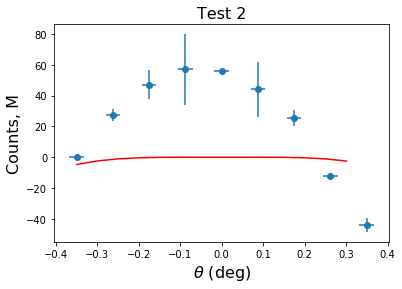

In [159]:
# Test call of makePlots function
makePlots('slab-Index-of-Refraction2.csv')

###################### Test #: 2 ####################

   theta (deg)  theta_err (deg)  Counts (M)  new counts
0          -20              1.0           0         0.0
1          -15              1.0          55        55.0
2          -10              1.0          39        94.0
3           -5              1.0          20       114.0
4            0              1.0          -2       112.0
5            5              1.0         -24        88.0
6           10              1.0         -37        51.0
7           15              1.0         -75       -24.0
8           20              1.0         -64       -88.0
The bestfit for fit param n is: 1.9999987359852525
Error Values for M:  [0.0, 3.6666666666666674, 9.4, 22.8, 0, 17.6, 5.1000000000000005, 1.6000000000000003, 4.4]


###################### Test #: 3 ####################

   theta (deg)  theta_err (deg)  Counts (M)  new counts
0        -10.0              1.0           0         0.0
1         -7.5              1.0           6         6

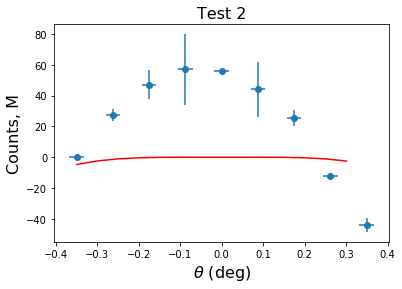

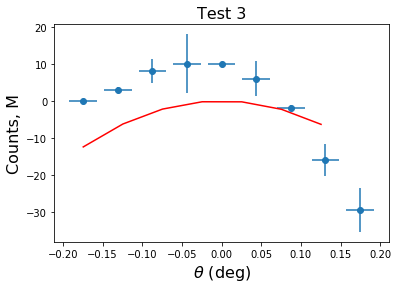

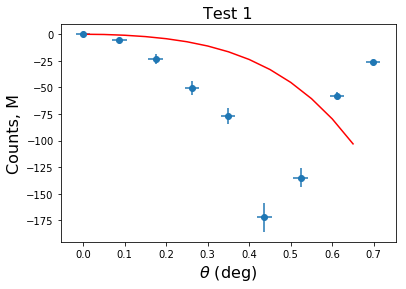

In [160]:
# Walking through entire slabs data directory and creating plots for each trial
indices = [] # from fit
count_index = []
for file, root,names in os.walk(path, topdown = True):
    for name in names:
        makePlots(name)
#         indices.append(nFit)
#         n = makePlots(name)[1]

        
        print('')
        
# theta_prime = arcsin(theta/n)

# sin(theta) = n sin(theta_prime)
# theta_prime is the phase shift from the path difference in the glass

In [111]:
print(indices)
print("std dev", np.std(indices))
print('')


[1.000248900992113, 1.0003151145490192, 1.0002970180496888]
std dev 2.7942340703587658e-05

